# Insulation domains
This notebook documents is used to detect domains in _A. castellanii_.

## Find domains

First, we want to find contact domains on the Hi-C map. We'll do this by first identifying borders, then corners and finding correspondance between borders and corners. Each domain should have 1 corner, with 2 borders (one vertically aligned, the other horizontally.

In [1]:
import os
import cooler
import numpy as np
import pandas as pd
import json
from chromosight.utils.preprocessing import detrend
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
os.chdir("/home/cmatthey/Repos/Acastellanii_legionella_infection/")

### Border detection

First, we use chromosight to detect domain borders. These borders are all independent: we don't know which pairs of borders form a domain

In [2]:
COOL = 'data/output/cool/all_merged.mcool::/resolutions/4000'
# Chromosight detection with standard borders kernel
!mkdir -p tmp/
!chromosight detect -p0.10 -W9 --min-separation 16000 -t12 -u 100 -z 100 -P borders $COOL tmp/borders

max_dist set to 0 based on config file.
min_dist set to 0 based on config file.
Matrix already balanced, reusing weights
Found 10860 / 11062 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0
 [=======-------------] 33.3% Kernel: 1, Iteration: 0
 [=============-------] 66.7% Kernel: 2, Iteration: 0
 [====================] 100.0% Kernel: 2, Iteration: 0[K
Minimum pattern separation is : 4
1635 patterns detected
Saving patterns in tmp/borders.tsv
Saving patterns in tmp/borders.json
Saving pileup plots in tmp/borders.pdf


### Setup corner kernel

Then we need to generate a new kernel that looks like a domain corner. This can be done with numpy:

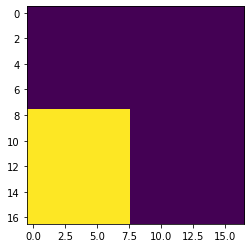

In [3]:
%matplotlib inline

# Generate a corner kernel
corner_kernel = np.zeros((17, 17))
hw = corner_kernel.shape[0] // 2
corner_kernel[hw:, :hw] = 1
plt.imshow(corner_kernel)

We then use chromosight to generate a template json file that will serve as a configuration for the kernel. We base the configuration on the loops preset, as corners are expected to be found in the same range, but the config can be tweaked a bit. Here we increase the max_dist value to 500kb to allow detecting very large domains. The adjusted configuration can then be saved in place of the template using the json module.

In [4]:
%%bash
# Generate chromosight config
chromosight generate-config corners

In [5]:
# Edit config
cfg = json.load(open('corners.json'))
cfg['name'] = 'corners'
cfg['max_dist'] = 200000
with open('corners.json', 'w') as cfg_handle:
    json.dump(cfg, cfg_handle, indent=4)

The kernel we generated is saved in place of the template kernel associated with the json file.

In [6]:
np.savetxt(cfg['kernels'][0], corner_kernel)

### Detecting corners

We now use the newly generated kernel to detect domain border. Each domain has one corner and two borders, so we will use these corner coordinates to pair borders into domains.

In [7]:
# Detect corners
!chromosight detect -M100000 -W11 -t12 -p 0.3 -u 90 -z 90 -k corners.json $COOL tmp/corners

min_dist set to 20000 based on config file.
min_separation set to 5000 based on config file.
Matrix already balanced, reusing weights
Found 10860 / 11062 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0
 [====================] 100.0% Kernel: 0, Iteration: 0[K
Minimum pattern separation is : 1
1002 patterns detected
Saving patterns in tmp/corners.tsv
Saving patterns in tmp/corners.json
Saving pileup plots in tmp/corners.pdf


### Assigning domains

We can now load all corners and borders into python and use pandas.`merge_asof` to perform a fuzzy merge. This allows to merge two tables on a numeric column with an error tolerance, which is convenient here, as chromosight detections can sometimes be a few pixels off.

We proceed as follow:
1. Merge borders and corners on their horizontal coordinates to find left-borders.
2. Merge borders and corners on their vertical coordinates to find right-borders.
3. Inner merge on left borders and right borders according to their matched corner to form pairs.

In [8]:
clr = cooler.Cooler(COOL)
tol = clr.binsize * 2

# load corners and borders
borders = pd.read_csv('tmp/borders.tsv', sep='\t')
corners = pd.read_csv('tmp/corners.tsv', sep='\t')


def make_domains(borders, corners, clr):
    """Merge domain borders and corners into domain intervals"""
    corners['corner_id'] = corners.index.values
    # Merge corners and borders horizontally -> left borders
    domains_l = pd.merge_asof(
        borders.loc[:, ['chrom1', 'start1']].sort_values('start1'),
        corners.loc[:, ['chrom1', 'start1', 'corner_id']].sort_values('start1'),
        by='chrom1',
        on='start1',
        direction='nearest',
        tolerance=tol
    ).dropna()

    # Merge corners and borders vertically -> right borders
    domains_r = pd.merge_asof(
        borders.loc[:, ['chrom2', 'start2']].sort_values('start2'),
        corners.loc[:, ['chrom2', 'start2', 'corner_id']].sort_values('start2'),
        by='chrom2',
        on='start2',
        direction='nearest',
        tolerance=tol
    ).dropna()

    # Merge left and right borders on corner id to find domain limits
    domains = domains_l.merge(domains_r, on='corner_id', how='inner')
    domains['bin1'] = domains.apply(lambda r: clr.extent(f'{r.chrom1}:{r.start1}-{r.start1}')[0], axis=1)
    domains['bin2'] = domains.apply(lambda r: clr.extent(f'{r.chrom2}:{r.start2}-{r.start2}')[0], axis=1)
    
    return domains

domains = make_domains(borders, corners, clr)

In [9]:
domains

,chrom1,start1,corner_id,chrom2,start2,bin1,bin2
0,scaffold_3,4000,104.0,scaffold_3,60000,1187,1201
1,scaffold_13,4000,456.0,scaffold_13,84000,5083,5103
2,scaffold_27,4000,857.0,scaffold_27,24000,9436,9441
3,scaffold_29,8000,895.0,scaffold_29,56000,9937,9949
4,scaffold_11,8000,396.0,scaffold_11,24000,4362,4366
...,...,...,...,...,...,...,...
472,scaffold_1,2076000,44.0,scaffold_1,2184000,519,546
473,scaffold_2,2092000,96.0,scaffold_2,2148000,1125,1139
474,scaffold_2,2188000,101.0,scaffold_2,2284000,1149,1173
475,scaffold_2,2304000,103.0,scaffold_2,2320000,1178,1182


### Visualisation

We can now visually assess the quality of domain calls by overlaying them on the Hi-C map. This is done by plotting vertical and horizontal segments linking borders and their matched corner.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<IPython.core.display.Javascript object>


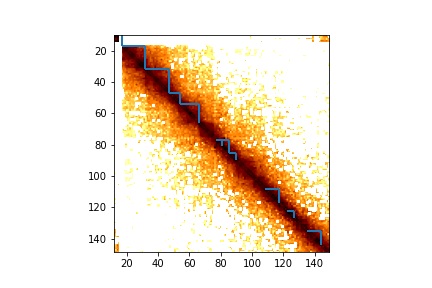

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


In [10]:
%matplotlib notebook

region = 'scaffold_2'
region_start, region_end = clr.extent(region)

sel_domains = domains.query(
    '(bin1 >= @region_start) & (bin1 < @region_end) & (bin2 >= @region_start) & (bin2 < @region_end)'
)
sel_domains.bin1 -= region_start
sel_domains.bin2 -= region_start

mat = clr.matrix(sparse=True, balance=True).fetch(region).toarray()
#mat = detrend(mat).toarray()

dom_lines = []
for x, y in zip(sel_domains.bin1, sel_domains.bin2):
    # Horizontal: l_border -> corner
    dom_lines.append([(x, x), (y, x)])
    # Vertical: r_border -> corner
    dom_lines.append([(y, y), (y, x)])

fig, ax = plt.subplots()
ax.imshow(np.log10(mat), cmap='afmhot_r', vmax=-1)
lc = mc.LineCollection(dom_lines, linewidths=2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

In [11]:
# save domains to a file
domains.corner_id = domains.corner_id.astype(int)
domains.sort_values(['chrom1', 'chrom2', 'start1', 'start2']).to_csv('tmp/domains.tsv', sep='\t', index=False)

<IPython.core.display.Javascript object>


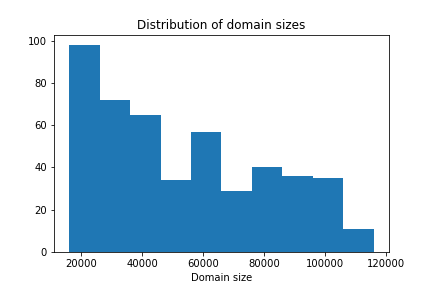

Text(0.5, 0, 'Domain size')

In [12]:
%matplotlib notebook
plt.hist(domains.start2 - domains.start1)
plt.title("Distribution of domain sizes")
plt.xlabel('Domain size')

### Appendix: Repeat operation for Neff
We run the same process for the Neff strain to compare domain sizes

In [13]:
COOL_NEFF = 'data/input/Neff.mcool::/resolutions/4000'
# Chromosight detection with standard borders kernel
!mkdir -p tmp/
!chromosight detect -p0.10 -W9 --min-separation 16000 -t12 -u 100 -z 100 -P borders $COOL_NEFF tmp/borders_neff
!chromosight detect -M100000 -W11 -t12 -p 0.3 -u 90 -z 90 -k corners.json $COOL_NEFF tmp/corners_neff

max_dist set to 0 based on config file.
min_dist set to 0 based on config file.
Matrix already balanced, reusing weights
Found 10507 / 11074 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_178-scaffold_178[K
Sub matrices extracted
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0
 [=======-------------] 33.3% Kernel: 1, Iteration: 078
 [=============-------] 66.7% Kernel: 2, Iteration: 078
 [====================] 100.0% Kernel: 2, Iteration: 08
Minimum pattern separation is : 4
1600 patterns detected
Saving patterns in tmp/borders_neff.tsv
Saving patterns in tmp/borders_neff.json
Saving pileup plots in tmp/borders_neff.pdf
min_dist set to 20000 based on config file.
min_separation set to 5000 based on config file.
Matrix already balanced, reusing weights
Found 10507 / 11074 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_178-scaffold_178[K
Sub matrices extracted
Detecting patterns...
 [

In [14]:
clr_neff = cooler.Cooler(COOL_NEFF)
# load corners and borders
borders_neff = pd.read_csv('tmp/borders_neff.tsv', sep='\t')
corners_neff = pd.read_csv('tmp/corners_neff.tsv', sep='\t')
domains_neff = make_domains(borders_neff, corners_neff, clr_neff)

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<IPython.core.display.Javascript object>


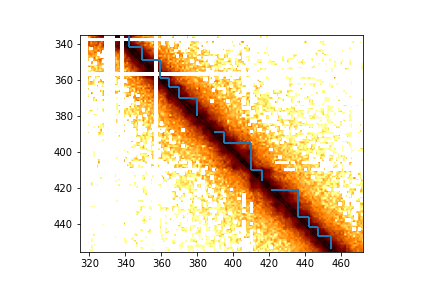

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


In [15]:
%matplotlib notebook

region = 'scaffold_1'
region_start, region_end = clr.extent(region)

sel_domains = domains_neff.query(
    '(bin1 >= @region_start) & (bin1 < @region_end) & (bin2 >= @region_start) & (bin2 < @region_end)'
)
sel_domains.bin1 -= region_start
sel_domains.bin2 -= region_start

mat = clr_neff.matrix(sparse=True, balance=True).fetch(region).toarray()
#mat = detrend(mat).toarray()

dom_lines = []
for x, y in zip(sel_domains.bin1, sel_domains.bin2):
    # Horizontal: l_border -> corner
    dom_lines.append([(x, x), (y, x)])
    # Vertical: r_border -> corner
    dom_lines.append([(y, y), (y, x)])

fig, ax = plt.subplots()
ax.imshow(np.log10(mat), cmap='afmhot_r', vmax=-1)
lc = mc.LineCollection(dom_lines, linewidths=2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

<IPython.core.display.Javascript object>


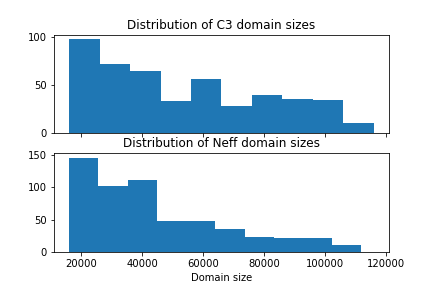

Text(0.5, 0, 'Domain size')

In [16]:
%matplotlib notebook
c3_sizes = domains.start2 - domains.start1
neff_sizes = domains_neff.start2 - domains_neff.start1
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].hist(c3_sizes)
axes[1].hist(neff_sizes)
axes[0].set_title("Distribution of C3 domain sizes")
axes[1].set_title("Distribution of Neff domain sizes")
plt.xlabel('Domain size')

In [31]:
import scipy.stats as ss

_, pval = ss.mannwhitneyu(c3_sizes, neff_sizes)
diff =  neff_sizes.mean() - c3_sizes.mean()

In [32]:
clr_neff.info['sum']

23613242

In [33]:
print(
    "The C3 strain has larger domains, but this is likely due to technical differences (protocols, batches, conditions):\n"
    f"Neff: {int(neff_sizes.mean())}, C3: {int(c3_sizes.mean())}, diff={int(diff)}bp, pval={pval:.2e}."
)

The C3 strain has larger domains, but this is likely due to technical differences (protocols, batches, conditions):
Neff: 44255, C3: 52301, diff=-8046bp, pval=5.45e-06.


In [34]:
# save domains to a file
domains_neff.corner_id = domains_neff.corner_id.astype(int)
domains_neff.sort_values(['chrom1', 'chrom2', 'start1', 'start2']).to_csv('tmp/domains_neff.tsv', sep='\t', index=False)